<a href="https://colab.research.google.com/github/Soorovickyy/CLIP/blob/main/CLIP%2Blog_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qg_qmap8
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-qg_qmap8
     |████████████████████████████████| 53 kB 1.4 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369328 sha256=9b944e087744f2c188699dbfcfc8108cb96614191c3e538c59f3cd8a53aad452
  Stored in directory: /tmp/pip-ephem-wheel-cache-4mjveku6/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
import os
import clip
import torch

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 58.6MiB/s]


In [ ]:
batch_size = 64
data_dir = '/content/drive/MyDrive/CLIP/COVID_IEEE'
dataset = datasets.ImageFolder(data_dir, transform=preprocess)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

In [ ]:
def get_features(dataloder):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloder):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train_loader)
test_features, test_labels = get_features(test_loader)

100%|██████████| 6/6 [02:00<00:00, 20.13s/it]


In [ ]:
from sklearn.model_selection import GridSearchCV
classifier = LogisticRegression()
parametrs = {'penalty': ['l1', 'l2', 'elasticnet'], 'tol': [1e-5, 1e-4, 1e-3], 'multi_class': ['auto', 'ovr', 'multinomial'],
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid_search_cv_clf = GridSearchCV(classifier, parametrs, cv=5, n_jobs=-1)
grid_search_cv_clf.fit(train_features, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
390 fits failed out of a total of 675.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solv

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': [1e-05, 0.0001, 0.001]})

In [ ]:
grid_search_cv_clf.best_params_

{'multi_class': 'auto', 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1e-05}

In [ ]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = best_clf.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(np.float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 95.906


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [ ]:
y_predicted_prob = best_clf.predict_proba(test_features)
y_onehot = pd.get_dummies(test_labels, columns=best_clf.classes_)
y_onehot = y_onehot.rename(columns={0: "Covid", 1: "Pneumonia", 2: "Normal"})

In [67]:
import plotly.graph_objects as go
import plotly.express as px
from sklearn.metrics import roc_curve, roc_auc_score

fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for i in range(y_predicted_prob.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_predicted_prob[:, i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    name = f"{y_onehot.columns[i]} (AUC={auc_score:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700, height=500
)
fig.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)

for i in range(y_predicted_prob.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_predicted_prob[:, i]

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    auc_score = average_precision_score(y_true, y_score)

    name = f"{y_onehot.columns[i]} (AP={auc_score:.2f})"
    fig.add_trace(go.Scatter(x=recall, y=precision, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='Recall',
    yaxis_title='Precision',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700, height=500
)
fig.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predictions, target_names=['Covid', 'Pneumonia', 'Normal']))

              precision    recall  f1-score   support

       Covid       1.00      0.96      0.98        95
   Pneumonia       0.94      0.97      0.95       127
      Normal       0.95      0.95      0.95       120

    accuracy                           0.96       342
   macro avg       0.96      0.96      0.96       342
weighted avg       0.96      0.96      0.96       342



[Text(0, 0.5, 'Covid'), Text(0, 1.5, 'Pneumonia'), Text(0, 2.5, 'Normal')]

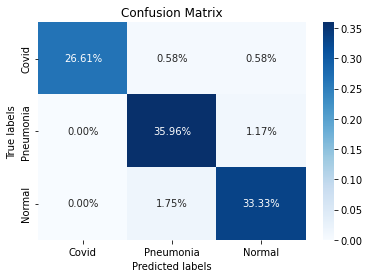

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     
from sklearn.metrics import confusion_matrix
ax= plt.subplot()
con_mat=confusion_matrix(test_labels, predictions)
sns.heatmap(con_mat/np.sum(con_mat), annot=True, fmt=".2%", cmap='Blues', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Covid', 'Pneumonia', 'Normal'])
ax.yaxis.set_ticklabels(['Covid', 'Pneumonia', 'Normal'])